In [1]:
import pandas as pd
from datetime import timedelta
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
country = 'ES'

In [3]:
df = pd.read_excel(f"./{country}/RFM_{country}_2023.xlsx", engine='openpyxl')

In [4]:
df.head(3)

,Customer Name,Monetary value,Frequency,Recency
0,A M INFINITY POOLS SL,14463.90,1,111
1,A CAMPIA DE LEMOS SL,7677.60,1,38
2,A PALLISER SL,3784.63,8,9


In [5]:
df2 = df[["Customer Name", "Monetary value", "Frequency", "Recency"]].copy()
df2.columns = ["customer", "monetary", "frequency", "recency"]

In [6]:
df2.head(3)

,customer,monetary,frequency,recency
0,A M INFINITY POOLS SL,14463.90,1,111
1,A CAMPIA DE LEMOS SL,7677.60,1,38
2,A PALLISER SL,3784.63,8,9


In [7]:
rfm=df2[['recency','frequency','monetary']]
rfm.index = df2["customer"]
rfm.head(3)

,recency,frequency,monetary
customer,,,
A M INFINITY POOLS SL,111,1,14463.90
A CAMPIA DE LEMOS SL,38,1,7677.60
A PALLISER SL,9,8,3784.63


# RFM Scoring

In [8]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['score']= rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str)
rfm['score'] = pd.to_numeric(rfm['score'])

In [9]:
pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1], retbins=True)

(customer
 A  M INFINITY POOLS SL              2
 A CAMPIA DE LEMOS SL                3
 A PALLISER SL                       4
 ABC PALAU SL441                     1
 ABC POOL PALMERA SL                 5
                                    ..
 XILEPLANT SL                        1
 ZABALETA EXCLUSIVAS SANITARIASSL    1
 ZALTARI SERVICIOS SL                4
 ZAMORAGUA SL                        2
 ZUNFER SA                           1
 Name: recency, Length: 990, dtype: category
 Categories (5, int64): [5 < 4 < 3 < 2 < 1],
 array([  1. ,   4.8,  24. ,  67. , 242. , 362. ]))

In [10]:
pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5], retbins=True)[1]

array([  1. , 198.8, 396.6, 594.4, 792.2, 990. ])

In [11]:
pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5], retbins=True)[1]

array([-1.8468000e+02,  5.2934000e+02,  1.8111700e+03,  5.3745300e+03,
        1.7651072e+04,  7.6627750e+05])

In [12]:
segment_dictionary = {"Champion TOP": [555, 545, 554],
                      "Growing Champion": [544, 454, 455, 445],
                      "Loyal Customer": [543,444,435,355,354,345,344,335],
                      "Potential Loyalist": [553,551,552,541,542,533,532,531,452,451,442,441,431,453,433,432,423,353,352,351,342,341,333,323],
                      "New Customer": [512,511,422,421,412,411,311],
                      "Promising": [525,524,523,522,521,515,514,513,425,424,413,414,415,315,314,313],
                      "Need Attention": [535,534,443,434,343,334,325,324],
                      "Cannot Lose Them": [155,154,144,214,215,115,114,113],
                      "About To Sleep": [331,321,312,221,213],
                      "At Risk": [255,254,245,244,253,252,243,242,235,234,225,224,153,152,145,143,142,135,134,133,125,124],
                      "Hibernating": [332,322,231,241,251,233,232,223,222,132,123,122,212,211],
                      "Lost": [111,112,121,131,141,151]
                      }

def rfm_segment(score):
    for k, v in segment_dictionary.items():
        if score in v:
            return k


In [13]:
rfm['segment'] = rfm['score'].apply(lambda score : rfm_segment(score))
#rfm['cluster'] = 3
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score,segment
customer,,,,,,,,
A M INFINITY POOLS SL,111,1,14463.90,2,1,4,214,Cannot Lose Them
A CAMPIA DE LEMOS SL,38,1,7677.60,3,1,4,314,Promising
A PALLISER SL,9,8,3784.63,4,3,3,433,Potential Loyalist
ABC PALAU SL441,291,3,279.00,1,2,1,121,Lost
ABC POOL PALMERA SL,2,13,15049.82,5,4,4,544,Growing Champion


<Figure size 14400x14400 with 0 Axes>

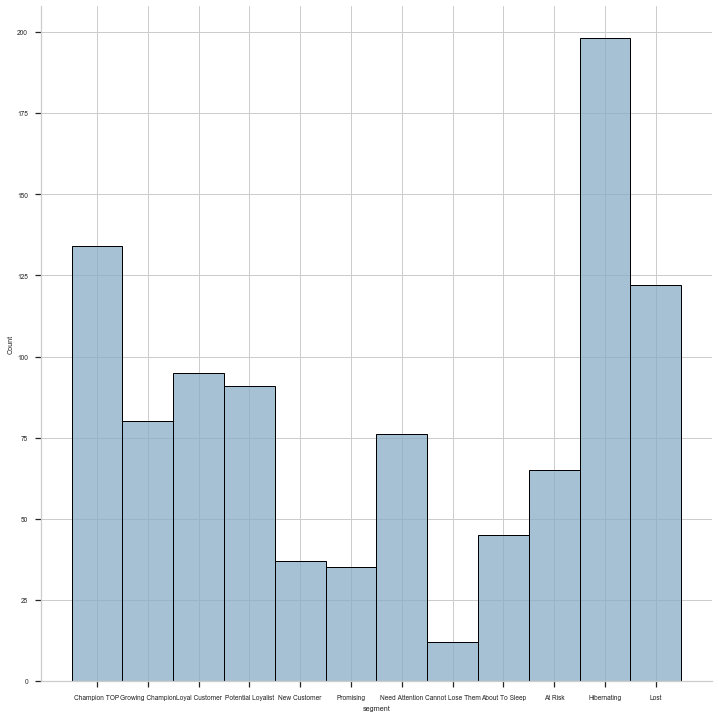

In [14]:
rfm['segment'] = pd.Categorical(rfm['segment'], categories=segment_dictionary.keys())

plt.figure(figsize=(200,200))
sns.set_context("notebook", font_scale=0.6)
sns.set_palette('twilight')
sns.displot(rfm['segment'], height=10)

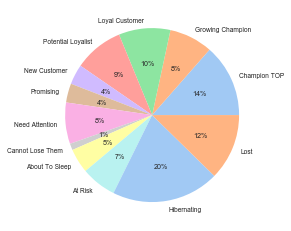

In [15]:
colors = sns.color_palette("pastel", n_colors=12)
plt.pie(rfm.groupby('segment').size(),labels=rfm.groupby('segment').size().index, colors = colors, autopct='%.0f%%')
plt.show()

In [16]:
rfm.groupby('segment').agg({
    'recency' : ['mean', 'min','max'],
    'frequency' : ['mean', 'min','max'],
    'monetary' : ['mean','min','max','count']
})

recency             frequency                monetary  \
                          mean  min  max        mean min   max          mean   
segment                                                                        
Champion TOP          2.417910    1    4  114.619403  10  2500  55348.080149   
Growing Champion      7.875000    2   24   36.025000   9   101  28188.805875   
Loyal Customer       23.663158    2   67   15.463158   4    59  15149.898211   
Potential Loyalist   19.351648    2   66    9.395604   2    90   2748.332637   
New Customer         19.378378    6   66    1.648649   1     4    536.211622   
Promising            25.028571    2   67    1.742857   1     3   7034.124286   
Need Attention       28.986842    2   66    8.828947   2    22   9350.185789   
Cannot Lose Them    203.833333   96  326    6.083333   1    27   9883.622500   
About To Sleep      106.155556   26  241    2.155556   1     6    668.610444   
At Risk             175.784615   68  300   12.584615   2    98   8222.160154   
Hibernating         175.929293   26  359    3.383838   1    10   1296.134192   
Lost                308.008197  244  362    1.393443   1     6    292.838607   

                                              
                        min        max count  
segment                                       
Champion TOP        5837.00  766277.50   134  
Growing Champion    5644.54  130359.37    80  
Loyal Customer      2311.40  101895.16    95  
Potential Loyalist   181.47    5300.07    91  
New Customer           0.00    1539.86    37  
Promising            180.92   24961.75    35  
Need Attention      1922.14   40177.05    76  
Cannot Lose Them    2869.30   26183.74    12  
About To Sleep         0.00    2657.85    45  
At Risk              664.34   77689.49    65  
Hibernating           27.38    5086.97   198  
Lost                -184.68    1664.00   122

In [17]:
rfm

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score,segment
customer,,,,,,,,
A M INFINITY POOLS SL,111,1,14463.90,2,1,4,214,Cannot Lose Them
A CAMPIA DE LEMOS SL,38,1,7677.60,3,1,4,314,Promising
A PALLISER SL,9,8,3784.63,4,3,3,433,Potential Loyalist
ABC PALAU SL441,291,3,279.00,1,2,1,121,Lost
ABC POOL PALMERA SL,2,13,15049.82,5,4,4,544,Growing Champion
...,...,...,...,...,...,...,...,...
XILEPLANT SL,325,1,591.19,1,1,2,112,Lost
ZABALETA EXCLUSIVAS SANITARIASSL,331,2,394.21,1,2,1,121,Lost
ZALTARI SERVICIOS SL,16,5,404.98,4,3,1,431,Potential Loyalist


In [18]:
rfm1 = rfm.copy()

# Data Description

In [19]:
segment_df = rfm1.groupby('segment').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max','count']
})
segment_df

recency             frequency                monetary  \
                          mean  min  max        mean min   max          mean   
segment                                                                        
Champion TOP          2.417910    1    4  114.619403  10  2500  55348.080149   
Growing Champion      7.875000    2   24   36.025000   9   101  28188.805875   
Loyal Customer       23.663158    2   67   15.463158   4    59  15149.898211   
Potential Loyalist   19.351648    2   66    9.395604   2    90   2748.332637   
New Customer         19.378378    6   66    1.648649   1     4    536.211622   
Promising            25.028571    2   67    1.742857   1     3   7034.124286   
Need Attention       28.986842    2   66    8.828947   2    22   9350.185789   
Cannot Lose Them    203.833333   96  326    6.083333   1    27   9883.622500   
About To Sleep      106.155556   26  241    2.155556   1     6    668.610444   
At Risk             175.784615   68  300   12.584615   2    98   8222.160154   
Hibernating         175.929293   26  359    3.383838   1    10   1296.134192   
Lost                308.008197  244  362    1.393443   1     6    292.838607   

                                              
                        min        max count  
segment                                       
Champion TOP        5837.00  766277.50   134  
Growing Champion    5644.54  130359.37    80  
Loyal Customer      2311.40  101895.16    95  
Potential Loyalist   181.47    5300.07    91  
New Customer           0.00    1539.86    37  
Promising            180.92   24961.75    35  
Need Attention      1922.14   40177.05    76  
Cannot Lose Them    2869.30   26183.74    12  
About To Sleep         0.00    2657.85    45  
At Risk              664.34   77689.49    65  
Hibernating           27.38    5086.97   198  
Lost                -184.68    1664.00   122

In [20]:
score_df = rfm1.groupby('score').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max','count']
})
score_df

recency             frequency                monetary            \
             mean  min  max        mean min   max          mean       min   
score                                                                       
111    312.600000  244  362    1.053333   1     2    153.751467   -184.68   
112    308.894737  250  362    1.000000   1     1    925.153684    545.58   
113    309.000000  292  326    1.000000   1     1   2932.850000   2869.30   
121    296.760000  251  362    2.280000   2     3    217.315200      0.00   
122    299.807692  248  347    2.576923   2     4    990.747308    550.85   
...           ...  ...  ...         ...  ..   ...           ...       ...   
544      2.863636    2    4   16.909091   9    23  10390.254091   5644.54   
545      2.545455    1    4   17.727273  10    24  34564.829091  20241.94   
553      2.333333    2    3   40.666667  32    52   4372.306667   3058.32   
554      2.555556    1    4   55.185185  25   201  12678.766667   5837.00   
555      2.364583    1    4  142.437500  25  2500  69730.238750  17857.44   

                        
             max count  
score                   
111       527.38    75  
112      1664.00    19  
113      2996.40     2  
121       513.15    25  
122      1617.11    26  
...          ...   ...  
544     17427.42    22  
545     54749.03    11  
553      5190.57     3  
554     17596.19    27  
555    766277.50    96  

[94 rows x 10 columns]

In [21]:
rfm1.to_excel(f"./{country}/database-{country}-2023.xlsx")
segment_df.to_excel(f"./{country}/segment-explanation-{country}-2023.xlsx")
score_df.to_excel(f"./{country}/score-explanation-{country}-2023.xlsx")

In [22]:
STOP

NameError: name 'STOP' is not defined

## Outliers


In [ ]:
rfm1 = rfm
plt.boxplot(rfm1.recency)
Q1 = rfm1.recency.quantile(0.25)
Q3 = rfm1.recency.quantile(0.75)
IQR = Q3 - Q1
rfm1 = rfm1[(rfm1.recency >= Q1 - 3*IQR) & (rfm1.recency <= Q3 + 3*IQR)]

In [ ]:
plt.boxplot(rfm1.frequency)
Q1 = rfm1.frequency.quantile(0.25)
Q3 = rfm1.frequency.quantile(0.75)
IQR = Q3 - Q1
rfm1 = rfm1[(rfm1.frequency >= Q1 - 3*IQR) & (rfm1.frequency <= Q3 + 3*IQR)]


In [ ]:
plt.boxplot(rfm1.monetary)
Q1 = rfm1.monetary.quantile(0.25)
Q3 = rfm1.monetary.quantile(0.75)
IQR = Q3 - Q1
rfm1 = rfm1[(rfm1.monetary >= (Q1 - 3*IQR)) & (rfm1.monetary <= (Q3 + 3*IQR))]

## K-Means
We will use the elbow method to determine the optimal amount of clusters. If we pick more clusters than necessary the added clusters will not be more descriptive of the data and will increase the amount of distortion. Some clusters will also be very small.

In [ ]:
scaler = StandardScaler()
x_scaled=scaler.fit(rfm2)
x_scaled=scaler.fit_transform(rfm2)

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(x_scaled)
visualizer.show()

In [ ]:
kmeans_scaled = KMeans(3)
kmeans_scaled.fit(x_scaled)
identified_clusters = kmeans_scaled.fit_predict(rfm2)
clusters_scaled = rfm2.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)

In [ ]:
rfm2['cluster']= clusters_scaled['cluster_pred']
rfm2['segment']= rfm1['segment']

In [ ]:
rfm2 = pd.concat([rfm2,rfm[["recency", "frequency", "monetary", "cluster", "segment"]]]).reset_index().drop_duplicates(subset='customer', keep='first').set_index('customer')
rfm2[["recency_score", "frequency_score", "monetary_score", "score"]] = rfm[["recency_score", "frequency_score", "monetary_score", "score"]]

In [ ]:
print(identified_clusters)
sns.set(style="darkgrid")
print(" Our cluster centers are as follows")
print(kmeans_scaled.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster", data=rfm2)
rfm2.groupby(['cluster']).count()

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=rfm2['recency']
yline=rfm2['frequency']
zline=rfm2['monetary']

ax.scatter3D(xline, zline,yline,c=rfm2['cluster'])
ax.view_init(30, 60)